Generated synthetic time series data with 4 folds
Total samples: 100000
Number of features: 100
Fold 1: Train samples: 20000, Test samples: 20000
Fold 1: Train positive ratio: 0.403, Test positive ratio: 0.406
Fold 2: Train samples: 40000, Test samples: 20000
Fold 2: Train positive ratio: 0.404, Test positive ratio: 0.402
Fold 3: Train samples: 60000, Test samples: 20000
Fold 3: Train positive ratio: 0.404, Test positive ratio: 0.405
Fold 4: Train samples: 80000, Test samples: 20000
Fold 4: Train positive ratio: 0.404, Test positive ratio: 0.410


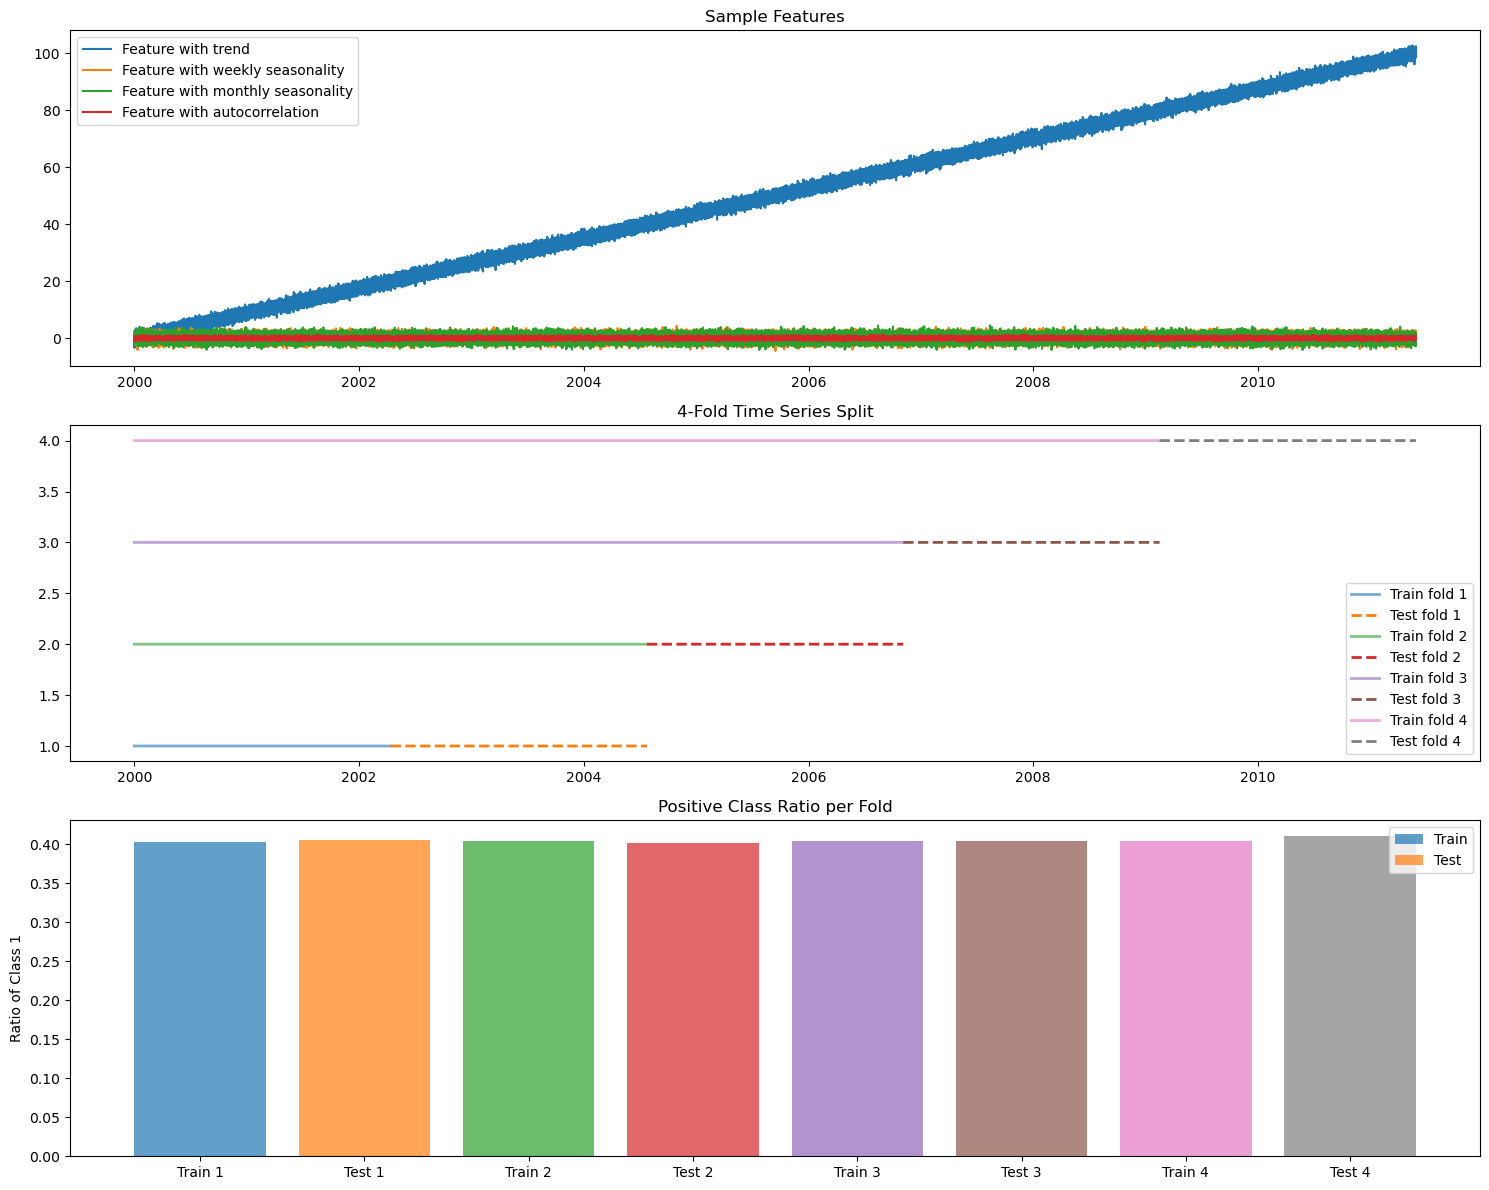

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import TimeSeriesSplit
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

DATA_DIR = '/home/jovyan/data'  # Directory to save the generated data

N_SAMPLES = 100_000
N_FEATURES = 100

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic time series data
def generate_synthetic_data(n_samples=1000, n_features=100):
    # Create date range
    start_date = datetime(2000, 1, 1)
    dates = [start_date + timedelta(hours=i) for i in range(n_samples)]
    
    # Generate features and target using make_classification
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=int(n_features * 0.2),  # 70% of features are informative
        n_redundant=int(n_features * 0.1),    # 10% are redundant
        n_repeated=int(n_features * 0.05),    # 5% are repeated
        class_sep=1.5,                        # Class separation
        flip_y=0.05,                          # Label noise
        weights=[0.6, 0.4],                   # Class imbalance: 60% class 0, 40% class 1
        random_state=42
    )
    
    # Add time dependency to features (trend and seasonality)
    time_idx = np.arange(n_samples)
    
    # Add trend component to some features
    for i in range(0, n_features, 4):  # Every 4th feature gets a trend
        X[:, i] += 0.001 * time_idx
    
    # Add weekly seasonality to some features
    for i in range(1, n_features, 4):  # Every 4th feature (offset by 1) gets weekly seasonality
        X[:, i] += 0.3 * np.sin(2 * np.pi * time_idx / 7)
    
    # Add monthly seasonality to some features
    for i in range(2, n_features, 4):  # Every 4th feature (offset by 2) gets monthly seasonality
        X[:, i] += 0.5 * np.sin(2 * np.pi * time_idx / 30)
    
    # Add autocorrelation to some features
    for i in range(3, n_features, 4):  # Every 4th feature (offset by 3) gets autocorrelation
        for j in range(1, n_samples):
            X[j, i] = 0.8 * X[j-1, i] + 0.2 * X[j, i]
    
    # Create DataFrame
    df = pd.DataFrame({f'feature_{i}': X[:, i] for i in range(n_features)})
    df['date'] = dates
    df['target'] = y
    
    # Reorder columns to have date first
    cols = df.columns.tolist()
    cols = ['date'] + [col for col in cols if col != 'date' and col != 'target'] + ['target']
    df = df[cols]
    
    return df

# Generate data
df = generate_synthetic_data(n_samples=N_SAMPLES, n_features=N_FEATURES)

# Create 4-fold time series split
tscv = TimeSeriesSplit(n_splits=4)

# Plot the data and the folds
plt.figure(figsize=(15, 12))

# Plot a few representative features
plt.subplot(3, 1, 1)
plt.plot(df['date'], df['feature_0'], label='Feature with trend')
plt.plot(df['date'], df['feature_1'], label='Feature with weekly seasonality')
plt.plot(df['date'], df['feature_2'], label='Feature with monthly seasonality')
plt.plot(df['date'], df['feature_3'], label='Feature with autocorrelation')
plt.legend()
plt.title('Sample Features')

# Plot the folds
plt.subplot(3, 1, 2)
for i, (train_idx, test_idx) in enumerate(tscv.split(df)):
    train_fold = np.zeros(len(df))
    train_fold[train_idx] = i + 1
    
    test_fold = np.zeros(len(df))
    test_fold[test_idx] = i + 1
    
    plt.step(df['date'][train_idx], train_fold[train_idx], where='post', 
             label=f'Train fold {i+1}', lw=2, alpha=0.6)
    plt.step(df['date'][test_idx], test_fold[test_idx], where='post', 
             linestyle='--', label=f'Test fold {i+1}', lw=2)
plt.title('4-Fold Time Series Split')
plt.legend()

# Add class distribution visualization
plt.subplot(3, 1, 3)
for i, (train_idx, test_idx) in enumerate(tscv.split(df)):
    train_pos_ratio = df['target'].iloc[train_idx].mean()
    test_pos_ratio = df['target'].iloc[test_idx].mean()
    
    plt.bar(i*2, train_pos_ratio, width=0.8, alpha=0.7, label='Train' if i==0 else "")
    plt.bar(i*2+1, test_pos_ratio, width=0.8, alpha=0.7, label='Test' if i==0 else "")

plt.xticks(np.arange(8), ['Train 1', 'Test 1', 'Train 2', 'Test 2', 'Train 3', 'Test 3', 'Train 4', 'Test 4'])
plt.title('Positive Class Ratio per Fold')
plt.ylabel('Ratio of Class 1')
plt.legend()

# Save the data to CSV files - one with all data and separate files for each fold
df.to_parquet(os.path.join(DATA_DIR,'synthetic_timeseries_all.parquet'), index=False)

print("Generated synthetic time series data with 4 folds")
print(f"Total samples: {len(df)}")
print(f"Number of features: {len(df.columns) - 2}")  # -2 for date and target

# Write each fold to separate files
for i, (train_idx, test_idx) in enumerate(tscv.split(df)):
    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]
    
    train_df.to_parquet(os.path.join(DATA_DIR, f'ts_fold_{i+1}_train.parquet'), index=False)
    test_df.to_parquet(os.path.join(DATA_DIR, f'ts_fold_{i+1}_test.parquet'), index=False)
    
    print(f"Fold {i+1}: Train samples: {len(train_df)}, Test samples: {len(test_df)}")
    print(f"Fold {i+1}: Train positive ratio: {train_df['target'].mean():.3f}, Test positive ratio: {test_df['target'].mean():.3f}")

plt.tight_layout()
plt.savefig('/home/jovyan/images/synthetic_timeseries_visualization.png')
plt.show()